
https://www.tensorflow.org/tutorials/images/transfer_learning

In [107]:
# load Tensorboard
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [189]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import os
import datetime

In [270]:
# Opzet datum voor het opslaan van een bestand.
from datetime import datetime 
now = datetime.now()

# dd/mm/YY
dt_save = now.strftime("%d%m%Y")
print("ddmmyyyy =", dt_save)


ddmmyyyy = 07112022


<h4>Warning blokker</h4>
<p>De lagen in een model geven een warning. De code hieronder blokced het tonen hiervan.</p>    
    

In [109]:
tf.get_logger().setLevel('ERROR')

In [110]:
# load dataset 

test_data_dir = '../data/Test'
train_data_dir = '../data/Train'


data_dir = pathlib.Path(train_data_dir)
test_dir = pathlib.Path(test_data_dir)
edgeFiles = list()
testFiles = list()

for filename in os.listdir(train_data_dir):
    imgAppleDirectory = os.path.join(train_data_dir, filename)
    edgeFiles.append(imgAppleDirectory)
    # print(edgeFiles)
    
for filename in os.listdir(test_data_dir):
    imgAppleTestDirectory = os.path.join(test_data_dir, filename)
    testFiles.append(imgAppleTestDirectory) 
    # print(testFiles)

['../data/Test/Scab_Apple']
['../data/Test/Scab_Apple', '../data/Test/.DS_Store']
['../data/Test/Scab_Apple', '../data/Test/.DS_Store', '../data/Test/Normal_Apple']
['../data/Test/Scab_Apple', '../data/Test/.DS_Store', '../data/Test/Normal_Apple', '../data/Test/Blotch_Apple']
['../data/Test/Scab_Apple', '../data/Test/.DS_Store', '../data/Test/Normal_Apple', '../data/Test/Blotch_Apple', '../data/Test/Rot_Apple']


In [111]:
batch_size = 32
img_size= (360, 360)

In [112]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

Found 383 files belonging to 4 classes.
Using 307 files for training.


In [113]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

Found 383 files belonging to 4 classes.
Using 76 files for validation.


In [114]:
# Test set 

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

Found 120 files belonging to 4 classes.


In [115]:
# create a test set

val_batches = tf.data.experimental.cardinality(test_ds)
test_dataset = test_ds.take(val_batches // 5)
val_ds = test_ds.skip(val_batches // 5)

In [116]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 4
Number of test batches: 4


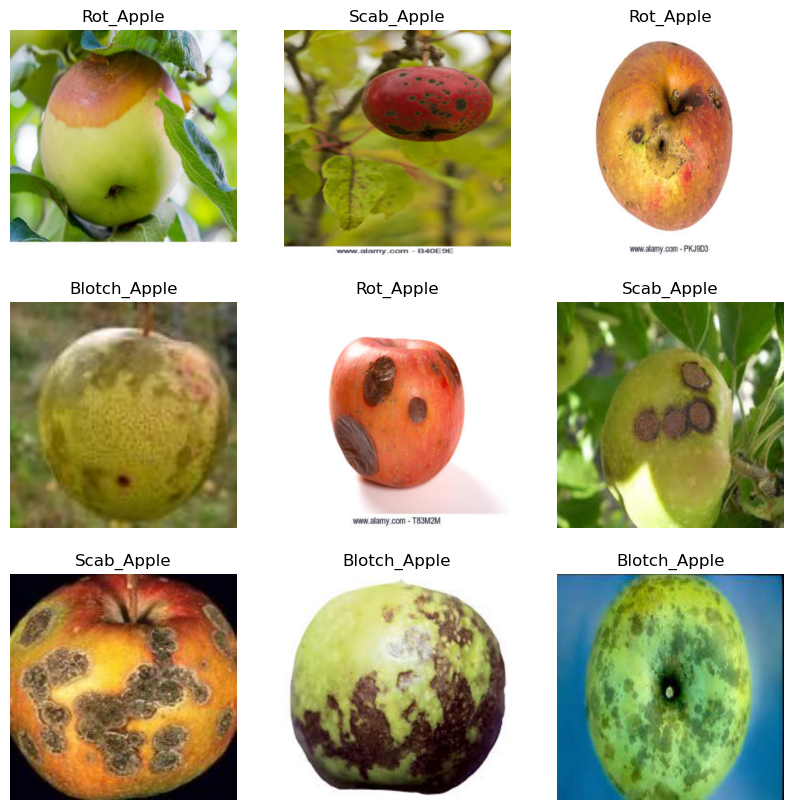

In [117]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [118]:
# confic dataset for performence 
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [119]:
# add augmentation
img_height = 360
img_width = 360

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width,3)),
  layers.RandomRotation(45.5),
  layers.RandomZoom(0.6),  
])

In [120]:
# augmentation toegevoegen
image, label = next(iter(train_ds))
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

<h4>Base Mobel</h4>
<p>Hier wordt het voorgetrainde model ingeladen</p>

In [121]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [122]:
IMG_SHAPE = img_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [123]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
# print(feature_batch.shape)

In [124]:
#Freeze the convolutional base
base_model.trainable = False

<h4>Classification head</h4>

In [125]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)

In [126]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

In [127]:
#base model architecture
# base_model.summary()

In [199]:
num_classes = 4
inputs = tf.keras.Input(shape=(360, 360, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
preds=Dense(num_classes,activation='relu')(x)
model = tf.keras.Model(inputs, outputs=preds)

In [200]:
for i,layer in enumerate(model.layers):
    print(i,layer.name)

0 input_11
1 sequential_2
2 tf.math.truediv_7
3 tf.math.subtract_7
4 mobilenetv2_1.00_224
5 global_average_pooling2d_4
6 dropout_7
7 dense_7


<h4>Model</h4>

In [129]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [130]:
# model.summary()

In [131]:
len(model.trainable_variables)

2

<h4>Model Training</h4>

In [132]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

4/4 [==============================] - 8s 2s/step - loss: 0.6322 - accuracy: 0.2333


In [133]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.63
initial accuracy: 0.23


In [134]:
# add Tensorboard
log_dir = "logs/fit" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [135]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    callbacks=[tensorboard_callback])

Epoch 1/10
10/10 [==============================] - 33s 3s/step - loss: 0.6023 - accuracy: 0.2671 - val_loss: 0.3908 - val_accuracy: 0.2167
Epoch 2/10
10/10 [==============================] - 25s 2s/step - loss: 0.1968 - accuracy: 0.2801 - val_loss: 0.1791 - val_accuracy: 0.2083
Epoch 3/10
10/10 [==============================] - 26s 3s/step - loss: 0.0596 - accuracy: 0.2573 - val_loss: -0.0031 - val_accuracy: 0.1917
Epoch 4/10
10/10 [==============================] - 25s 2s/step - loss: -0.1981 - accuracy: 0.2248 - val_loss: -0.1647 - val_accuracy: 0.1917
Epoch 5/10
10/10 [==============================] - 28s 3s/step - loss: -0.4496 - accuracy: 0.1987 - val_loss: -0.3094 - val_accuracy: 0.1833
Epoch 6/10
10/10 [==============================] - 25s 3s/step - loss: -0.5693 - accuracy: 0.1987 - val_loss: -0.4398 - val_accuracy: 0.2000
Epoch 7/10
10/10 [==============================] - 25s 2s/step - loss: -0.6068 - accuracy: 0.1954 - val_loss: -0.5605 - val_accuracy: 0.2000
Epoch 8/10


In [257]:
# folder path to save figureplot 
sp_freese = r'saved_models/tl_mobileNetV2/plt_val_acc/'
sc_freese = 0
# Iterate directory
for path in os.listdir(sp_freese):
    # check if current path is a file
    if os.path.isfile(os.path.join(sp_freese, path)):
        sc_freese += 1
print('File count:', sc_freese)

File count: 3


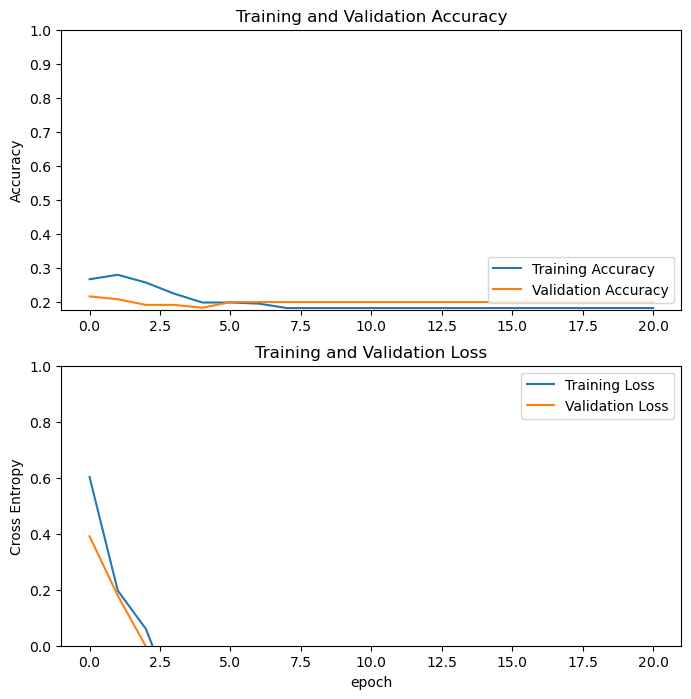

In [258]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('saved_models/tl_mobileNetV2/plt_val_acc/tl_freese_' + str(dt_save) + '_' +str(sc_freese) + '.png')
plt.show()

<h4>UN-FREESE</h4>

In [137]:
base_model.trainable = True

In [138]:
print("Aantal layers in het basis model: ", len(base_model.layers))

Aantal layers in het basis model:  154


In [139]:
fine_tune_at = 100

# Freeze alle layers voor 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

<h4>Het model terug samenstellen</h4>

In [140]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [141]:
# model.summary()

In [142]:
len(model.trainable_variables)

56

<h4>Voortzetting Model training, na de Un-Freese</h4>

In [143]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                    epochs=total_epochs,
                    initial_epoch=history.epoch[-1],
                    validation_data=val_ds,
                    callbacks=[tensorboard_callback])

Epoch 10/20
10/10 [==============================] - 41s 3s/step - loss: -4.0106 - accuracy: 0.1824 - val_loss: -7.7186 - val_accuracy: 0.2000
Epoch 11/20
10/10 [==============================] - 34s 3s/step - loss: -12.7414 - accuracy: 0.1824 - val_loss: -19.2793 - val_accuracy: 0.2000
Epoch 12/20
10/10 [==============================] - 33s 3s/step - loss: -22.4268 - accuracy: 0.1824 - val_loss: -29.5250 - val_accuracy: 0.2000
Epoch 13/20
10/10 [==============================] - 33s 3s/step - loss: -30.2374 - accuracy: 0.1824 - val_loss: -37.9077 - val_accuracy: 0.2000
Epoch 14/20
10/10 [==============================] - 33s 3s/step - loss: -36.2603 - accuracy: 0.1824 - val_loss: -44.7927 - val_accuracy: 0.2000
Epoch 15/20
10/10 [==============================] - 36s 4s/step - loss: -41.8731 - accuracy: 0.1824 - val_loss: -49.9837 - val_accuracy: 0.2000
Epoch 16/20
10/10 [==============================] - 35s 4s/step - loss: -47.0153 - accuracy: 0.1824 - val_loss: -54.5231 - val_accu

In [144]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

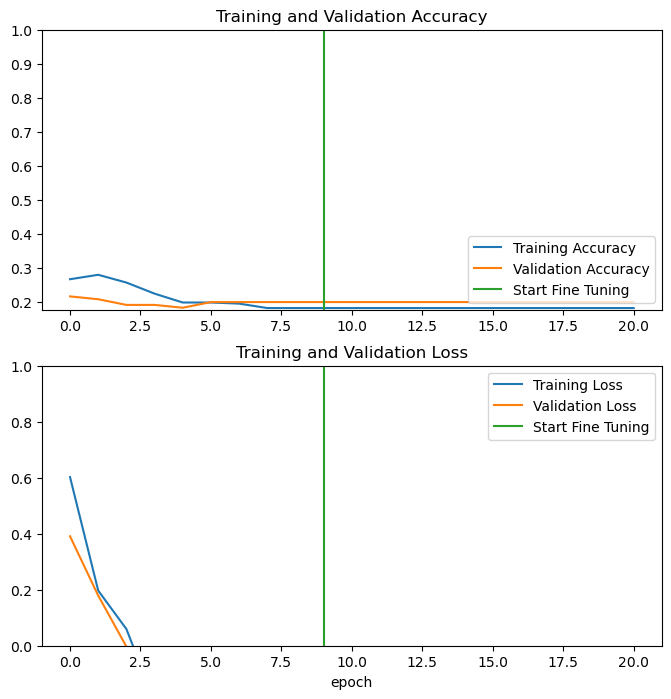

In [259]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0,1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('saved_models/tl_mobileNetV2/plt_val_acc/tl_UNfreese_' + str(dt_save) + '_' +str(sc_freese) + '.png')
plt.show()

In [263]:
# folder path to save model 
sp_model = r'saved_models/tl_mobileNetV2/model/'
sc_model = 0
# Iterate directory
for path in os.listdir(sp_model):
    # check if current path is a file
    if os.path.isfile(os.path.join(sp_model, path)):
        sc_model += 1
print('File count:', sc_model)

File count: 2


In [264]:
model.save('saved_models/tl_mobileNetV2/model/tl_' + str(dt_save) + '_' +str(sc_model) + '.h5')

<h4>Confusion Matrix</h4>

In [262]:
# folder path to save figureplot 
sp_matrix = r'saved_models/tl_mobileNetV2/plt_matrix/'
sc_matrix = 0
# Iterate directory
for path in os.listdir(sp_matrix):
    # check if current path is a file
    if os.path.isfile(os.path.join(sp_matrix, path)):
        sc_matrix += 1
print('File count:', sc_matrix)

File count: 1


4/4 [==============================] - 7s 1s/step


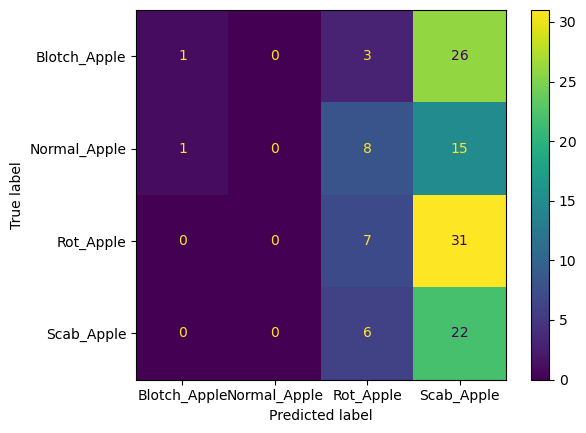

In [265]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

batchPredictions = model.predict(test_ds)
predicted_categories = tf.argmax(batchPredictions, axis=1)
true_categories = tf.concat([y for x, y in test_ds], axis=0)

# confusion_matrix(predicted_categories, true_categories)

confusion_matrix = confusion_matrix(true_categories, predicted_categories)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels = ['Blotch_Apple', 'Normal_Apple', 'Rot_Apple', 'Scab_Apple'])

cm_display.plot()
plt.savefig('saved_models/tl_mobileNetV2/plt_matrix/tl_matrix_' + str(dt_save) + '_' + str(sc_matrix) + '.png')
plt.show()


###### <h4>Evaluatie en voorspelling</h4>

In [148]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

4/4 [==============================] - 6s 1s/step - loss: -70.1773 - accuracy: 0.2000
Test accuracy : 0.20000000298023224


Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [0 2 0 2 2 2 2 1 3 1 0 3 2 2 1 3 3 3 2 3 1 1 1 3 3 0 3 2 2 0 2 2]


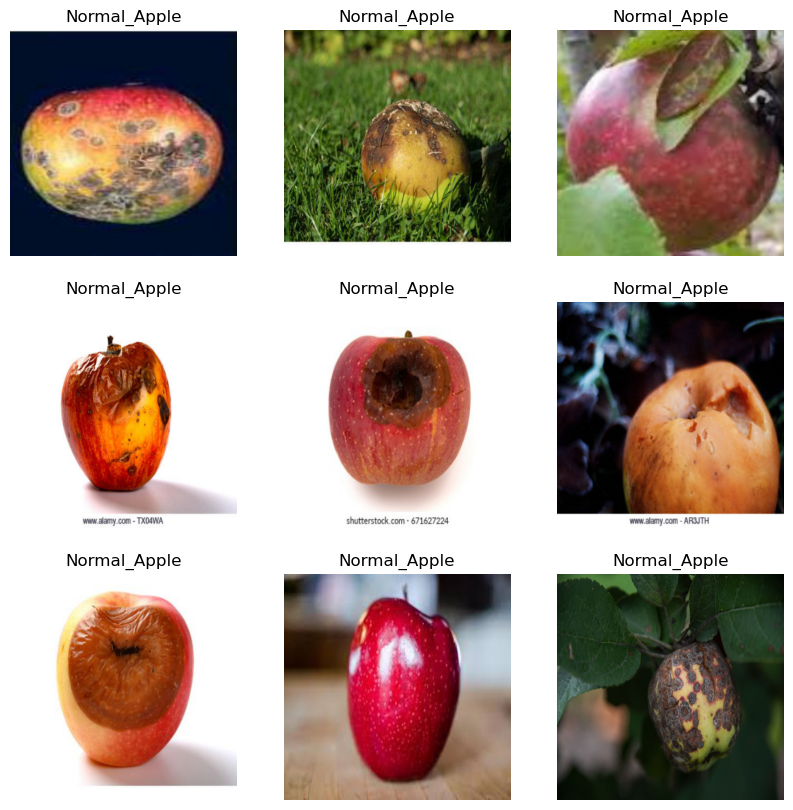

In [149]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [150]:
# run Tensorbord
%tensorboard --logdir logs/

Reusing TensorBoard on port 6006 (pid 90554), started 13:49:31 ago. (Use '!kill 90554' to kill it.)